# Report: Comparing domestic flights with train alternatives

In recent years, there has been a remarkable surge in global interest and concern surrounding the issue of climate change, reflecting an increasing recognition of its far-reaching consequences and the urgent need for collective action. Train operators such as Deutsche Bahn in Germany use tools such as their [UmweltMobilCheck](https://www.img-bahn.de/s3/prod/v/img_responsive/ecology/umc-grundlagenbericht.pdf) or [EcoPassenger](https://uic.org/sustainability/energy-efficiency-and-co2-emissions/article/ecopassenger) internationally to compare the benefits and drawbacks of taking a train in comparison to trains and cars with respect to duration and generated CO2 emissions. 

This report uses open data from domestic (=within Germany) [business flights of the municipality of Cologne](https://mobilithek.info/offers/-1005216978664916194). It compares the CO2 emissions of the domestic flights taken in the year 2019 with public alternatives such as trains. The main focus will be on duration of transport and estimated CO2 emission. As there are no public APIs to access the emission data, an emission calculator for the train alternatives will be provided to create a transparent answer. This project aims to have an automated data pipeline method of analyzing data sets such as the example. 

The question that interests us is: What drawbacks and benefits are there in taking the train instead of flying domestic? 

## Install dependencies
Initially, install all required dependencies. 

In [ ]:
import os
if os.path.basename(os.getcwd()) == "project":
    print("changing directory to root...")
    %cd ..
if os.path.isfile("requirements.txt"):
    print("installing requirements...")
    %pip install -r requirements.txt
from main import pipeline,showFirstRow, showFlightComparison, showEmissionComparison, showTime,showEmissions
import pandas as pd


## Dataset
#### Generation
Create a sqlite file of the collected information that automatically calculates the required data for the results by running the pipeline. First, 236 flight entries are pulled from [Datasource1](https://mobilithek.info/offers/-1005216978664916194) into `fluege.sqlite`. Then, 6519 train station entries are pulled from [Datasource2](https://data.deutschebahn.com/dataset/data-haltestellen/resource/21edf505-e97d-4c99-bcc9-a46e85f8620f.html) into `train_stations.sqlite`. By mapping the train stations to the corresponding airports in Germany, a combined raw data base of 107 domestic flight entries is created into `domestic_flights.sqlite`. For every flight, the durations and emissions are calculated and saved into `final.sqlite`. The final `pipeline()` creates the following database showing the first row as an example:

In [12]:
pipeline(verbose = False, use_real_durations = False)
showFirstRow()

,origin,destination,flight_duration,train_duration,train_emissions_A,train_emissions_B,flight_emissions,quantity
0,CGN,TXL,64,354,1860,26286,496000,4


#### Explanation of generated data
All 107 entries of the generated database represent a domestic flight from the original source. It states the origin and destination iata airport code, the actual flight duration, an estimated flight duration, the estimated train duration with respective train emissions A and B, as well as the flight emissions as stated in the original data source. The following entries were added to the original data source:
* flight_duration: Due to unavailabilty of open source flight duration data, the flight duration will be calculated and estimated according to the aerial distance. This is equivalent to common flight duration calculators as found online. Since there are few unique domestic connections in our database, an exact lookup of the connections can be used setting the flag `use_real_durations` to `True`.
* train_duration: As there is no open data on actual train durations available, the [HAFAS](https://www.hacon.de/en/portfolio/operator-business-products/) transport management system will be used to get real world train information.
* train_emissions_A: This assumes that all interregional trains such as ICE trains are fully carbon neutral and have such zero emissions. This is the theoretical value using the status-quo. However, the ICE trains in reality are not operated by pure green electricity as DB buys a certain part of green energy and internally books this factor for the ICE train operations. Further reading can be found [here](https://www.img-bahn.de/s3/prod/v/img_responsive/ecology/umc-grundlagenbericht.pdf) and [here](https://www.br.de/nachrichten/wirtschaft/faktenfuchs-wie-gruen-ist-die-deutsche-bahn,Sp7n6hB). 
* train_emissions_B: This is the emissions value for a train per km according to the [Umweltbundesamt](https://www.umweltbundesamt.de/bild/vergleich-der-durchschnittlichen-emissionen-0). It values regional trains at 93 g/km and interregional at 46 g/km of carbon emissions.

#### Plausibility check of the generated data
##### Flight durations
There are many non-open flight duration estimators as well as the real world information. Comparing the information of calculated duration vs real world data from July 2023 (choosing the shortest trip time) gets the following results for three different trips. The fourth column nonstop states if there was a nonstop flight available. Note the difference in duration when there is a flight with at least one stop.

In [3]:
showFlightComparison(3)

,trip,estimated_duration,actual_duration,nonstop
0,CGN-TXL,64,70,yes
1,CGN-FRA,40,180,no
2,CGN-MUC,62,70,yes


##### Train emissions
The train emission calculation states the two different approaches as stated above. For the 17 unique trips that have been undertaken, the three most taken trips examples are chosen to compare the plausibility of the used data by comparing them with the value of the [UmweltMobilChecker (UMC)](https://www.umweltmobilcheck.de/). The second column displays the calculated value as in train_emissions_A as stated above, the third column matches the corresponding setting at UMC by selecting the market based method which uses a green electricity model. The fourth column is the calculated value according to train_emissions_B and the fifth column matches it using the UMC by selecting the location based method. 

In [4]:
showEmissionComparison()

,trip,count,train_emission_A_own,market_based_UMC,train_emission_B_own,location_based_UMC
0,CGN-TXL,50,1860,2200,26286,15100
1,CGN-MUC,15,2697,2900,25927,15600
2,CGN-DRS,8,558,460,26180,16400


## Evaluation
What are the drawbacks and benefits from taking the train instead flying domestically? To answer our initial question, we evaluate the data using our two metrics time and emissions.  

### Time
By setting the `puffer_in_min` which takes into account a certain time required to be at the airport beforehand, the total time of flights can be manipulated. 

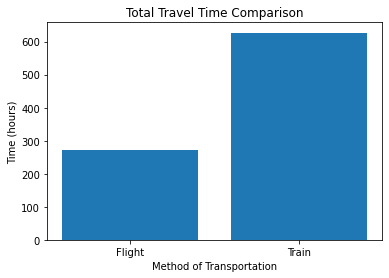

In [5]:
showTime(puffer_in_min = 90)

### Carbon Emissions
By analyzing the data, it seems like the last column `quantity` has already been multiplied into the total flight emissions. Therefore, this factor needs to be multiplied to create the total train emissions per trip as well. However, trains usually do not have a strictly limited capacity compared to airplanes and can fit additional people. As these distances are quite long, requiring a seat is reasonable thus this argument can be refuted. 


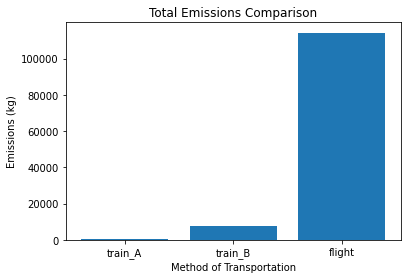

In [6]:
showEmissions()

### Conclusion 
Overall, it can be clearly seen that a compromise between emissions and time needs to be made. While trains operate on much lower carbon emissions than planes, they take significantly longer. However, especially for work trips, it might be possible to use that time on the train efficiently. 